## Training process for ECD507 Senior Capstone Project - F1Tenth ML Based Autonomous Race Car
### Contributors - Charles Hodgins, Rishabh Hegde, Dylan DiGiacomo, and Andrew Meccariello

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import ast

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


In [3]:
class DrivingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx,1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200, 66))  # Resize using OpenCV
        image = image / 255.0  # Normalize pixel values to [0,1]
        image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        steering_angle = float(self.data.iloc[idx, 3])
        throttle = float(self.data.iloc[idx, 4])
        lidar = torch.tensor(ast.literal_eval(self.data.iloc[idx, 2]))
               
        return image, lidar, torch.tensor([steering_angle, throttle], dtype=torch.float32)


In [13]:
# chunk = pd.read_csv(os.path.expanduser('~/training/data/driving_log.csv'),chunksize = 10000)
# print(len(df))

In [4]:

def filter_chunk(df):
    global first_chunk
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df = df[df["throttle"] != 0 ]
    df = df[df["lidar_list"] != ""]
    df = df[pd.notna(df["lidar_list"])]
    df = df[df["image_path"] != ""]
    def is_valid_image(img_path):
        return os.path.exists(img_path) and cv2.imread(img_path) is not None
    df_filtered = df[df.iloc[:, 1].apply(is_valid_image)]
    
    if first_chunk:
        df_filtered.to_csv(os.path.expanduser("~/training/data/driving_log2.csv"), mode='w', index=False, header=True)
        first_chunk = False
    else:
        df_filtered.to_csv(os.path.expanduser("~/training/data/driving_log2.csv"), mode='a', index=False, header=False)


    # Save the cleaned dataset

    df.head()
    
first_chunk = True

for chunk in pd.read_csv(os.path.expanduser("~/training/data/driving_log.csv"),chunksize = 10000):

    filter_chunk(chunk)
    # print(chunk.head())
    del chunk
    
print('done')

done


In [5]:

dataset = DrivingDataset(os.path.expanduser('~/training/data/driving_log2.csv'))
print(len(dataset))

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

24651


In [10]:
img,lidar, label = dataset[20]
print(lidar.shape)


torch.Size([721])


In [16]:
# Define CNN model
class CameraCNNModel(nn.Module):
    def __init__(self):
        super(CameraCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3840, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)  # Output: Steering angle and Throttle
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

import torch.nn.functional as F


class ResNet15(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,kernel_size = 7, stride = 1, padding = 'same')
        self.conv1_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv4_bn = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 'same')
        self.conv5_bn = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv6_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv6_bn = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv7_shortcut = nn.Conv2d(64,128, kernel_size = 2, stride = 2)
        self.conv7_shortcut_bn = nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv8_bn = nn.BatchNorm2d(128)

        self.conv9 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 'same')
        self.conv9_bn = nn.BatchNorm2d(128)

        self.conv10 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv10_maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv10_bn = nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv11_bn = nn.BatchNorm2d(256)
        self.conv11_shortcut = nn.Conv2d(128,256, kernel_size = 2, stride = 2)
        self.conv11_shortcut_bn = nn.BatchNorm2d(256)

        self.conv12 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv12_bn = nn.BatchNorm2d(256)

        self.conv13 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv13_bn = nn.BatchNorm2d(256)

        self.conv14 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 'same')
        self.conv14_bn = nn.BatchNorm2d(256)

        self.FC1 = nn.Linear(256*4*12,2)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv1_maxpool(x)
        x = F.relu(self.conv1_bn(nn.MaxPool2d(kernel_size=3,stride = 2,padding = 1)(x)))

        # first block
        x1 = F.relu(self.conv2_bn(self.conv2(x)))
        x1 = F.relu(self.conv3_bn(self.conv3(x1)))
        x = x1 + x 
        x1 = F.relu(self.conv4_bn(self.conv4(x)))
        x1 = F.relu(self.conv5_bn(self.conv5(x1)))
        x = x1 + x

        #second block
        x2 = F.relu(self.conv6_bn(self.conv6_maxpool(self.conv6(x))))
        x2 = F.relu(self.conv7_bn(self.conv7(x2)))
        # print(x2.shape)
        # print(self.conv7_shortcut_bn(self.conv7_shortcut(x)).shape)
        x = F.relu(x2 + self.conv7_shortcut_bn(self.conv7_shortcut(x)))
        x2 = F.relu(self.conv8_bn(self.conv8(x)))
        x2 = F.relu(self.conv9_bn(self.conv9(x2)))
        x = x2 + x

        x3 = F.relu(self.conv10_bn(self.conv10_maxpool(self.conv10(x))))
        x3 = F.relu(self.conv11_bn(self.conv11(x3)))
        x = F.relu(self.conv11_shortcut_bn(self.conv11_shortcut(x)))
        x3 = F.relu(self.conv12_bn(self.conv12(x3)))
        x3 = F.relu(self.conv13_bn(self.conv13(x3)))
        x3 = F.relu(self.conv14_bn(self.conv14(x3)))
        # print(x.shape)
        x = x + x3
        

        x = x.view(x.size(0),-1)
        x = self.FC1(x)
        return x


In [17]:
input("wait for training...")

''

In [18]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
print(device)
model = ResNet15().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, )

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for images,lidar,targets in dataloader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}')

# Save model
torch.save(model.state_dict(), os.path.expanduser('~/training/model.pth'))
print("Model training complete and saved as model.pth")

cuda


KeyboardInterrupt: 

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.backends.cudnn.enabled)  # Should return True
print(torch.version.cuda)

# print(model.state_dict())


485
torch.Size([1, 3, 66, 200])
tensor([0.4802, 2.1893])
tensor([[0.4851, 1.7566]], device='cuda:0')


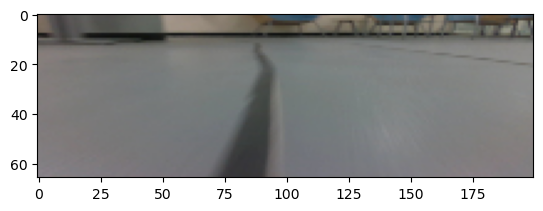

In [ ]:
checkpoint = torch.load(os.path.expanduser('~/training/model.pth'))
model = ResNet15().to(device)
model.load_state_dict(checkpoint)
model.eval()

idx = int(np.random.rand()*1000) % len(df)
print(idx)
img,lidar, label = dataset[idx]
img = img.to(device)
img = img.unsqueeze(0) 
img_ = img.to('cpu')
img_ = np.squeeze(img_)
img_ = np.transpose(img_, (1,2,0))  # Change shape to (C, H, W)
print(img.shape)

# print(img_.shape)

with torch.no_grad():
    output = model(img)
plt.imshow(img_)

print(label)
print(output)

In [6]:
input("Press Enter to continue...")


class LidarNet(nn.Module):
    def __init__(self):
        super(LidarNet, self).__init__()
        # expects input size of 721
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=24, kernel_size=10, stride=4) # output: (721-10)/4 + 1 = 178
        self.conv2 = nn.Conv1d(in_channels=24, out_channels=36, kernel_size=8, stride=4) # (178-8)/4 + 1 = 43
        self.conv3 = nn.Conv1d(in_channels=36, out_channels=48, kernel_size=4, stride=2) # (43-4)/2 + 1 = 20
        self.conv4 = nn.Conv1d(in_channels=48, out_channels=64, kernel_size=3, stride=1) # (20 -3)/1 + 1 = 1
        self.conv5 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1) # (18 - 3)/1 + 1 = 16

        self.fc1 = nn.Linear(1024, 512)  # (64 * 16) = 1024 -> 512
        self.fc2 = nn.Linear(512, 256) # 512 -> 256
        self.fc3 = nn.Linear(256, 100) # 256 -> 200
        self.fc4 = nn.Linear(100, 10) # 100 -> 10
        self.fc_out = nn.Linear(10, 2)  # 10 -> 2 Steering Angle & Speed

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # Flatten to (batch, 1024)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc_out(x)  # No activation for raw output
        return x


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to cuda when it begins to work
print(device)
model = LidarNet().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, )

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for images,lidar,targets in dataloader:
        lidar = lidar.unsqueeze(1)
        lidar, targets = lidar.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(lidar)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}')

# Save model
torch.save(model.state_dict(), os.path.expanduser('~/training/lidar_model.pth'))
print("Model training complete and saved as lidar_model.pth")

cuda


KeyboardInterrupt: 